**This exercise focuses on the deep learning and classication task. The total point is 17 points (16 points + 1 bonus point).<br/>**


1.   Data loading. [0.5 point]
2.   Data preparation. [5.5 point]
3.   Training. [6 point]
4.   Loss & accuracy plot. [1 point]
5.   Test set prediction. [1 point]
6.   Evaluation/metric. [0.5 point] 
7.   Prediction of individual image. [1.5 point]

[Click here to download the dataset of this exercise](https://drive.google.com/file/d/1ChimpR2v7rg6hHaQB-dHlN6W6WSK9Suj/view?usp=share_link)



# **0. Importing Libraries**


In [18]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **1. Data Loading**
* check some samples

**Let's take a quick look at the data. :)**

In [60]:
# set the path to dataset folder
path = r'C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\flowers'

# pick one kind of flower as example
example = r'C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\flowers\daisy'

Shape: (263, 320, 3)


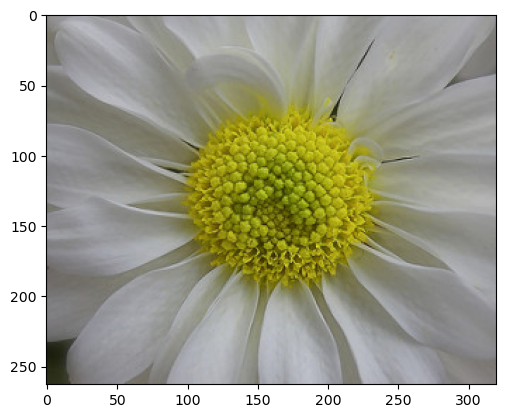

In [7]:
# show example image
img = mpimg.imread(example + '/100080576_f52e8ee070_n.jpg')
print('Shape:', img.shape)
plt.imshow(img)

**From the shape of image, we know there are 3 channels. <br/>
Let's check image channels separately**

Text(0.5, 1.0, 'Green Channel')

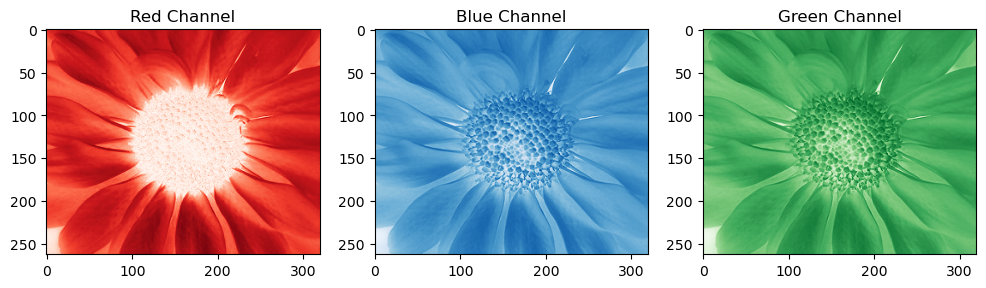

In [9]:
# [0.5 point] for this code block
# TODO: check 3 channels visually and separately 
red_channel = img[:,:,2]
blue_channel = img[:,:,1]
green_channel = img[:,:,0]

fig,axes = plt.subplots(1,3,figsize=(12,4))

axes[0].imshow(red_channel,cmap='Reds')
axes[0].set_title('Red Channel')

axes[1].imshow(blue_channel,cmap='Blues')
axes[1].set_title('Blue Channel')

axes[2].imshow(green_channel,cmap='Greens')
axes[2].set_title('Green Channel')
###

**From the image above, you can understand that they are not normalized (which is very expected), let's check the histogram of this image:**

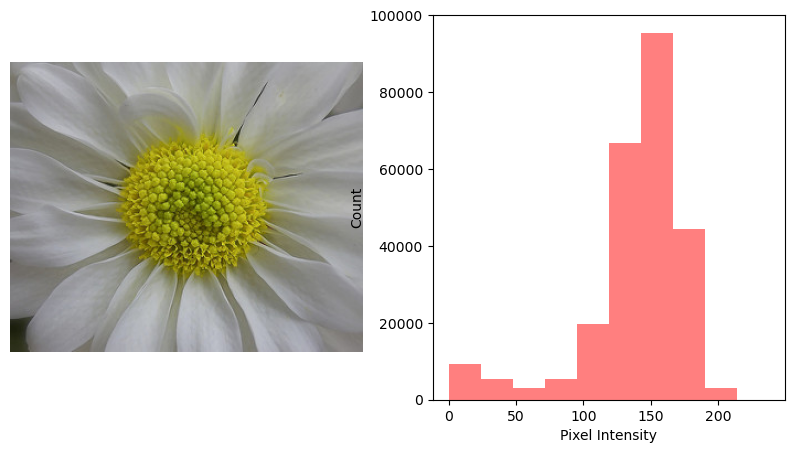

In [10]:
def plotHist(img):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    hist = plt.subplot(1,2,2)
    hist.set_ylabel('Count')
    hist.set_xlabel('Pixel Intensity')
    plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

plotHist(img)

# **2. Data preparation**


**Let's write the dataset transformation, including normalization.**

The "original" dataset is the original dataset, which we will split into two parts: test (20%) and training (80%).

**Bonus: besides normalization, can you try other image augmentation?**

In [61]:
transformer = {
    'original': transforms.Compose([
                                 transforms.Resize((220, 220)),
                                 transforms.ToTensor(), 
                                 transforms.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                                     (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
])
}

**pin_memory:** You know how sometimes your GPU memory shows that it’s full but you’re pretty sure that your model isn’t using that much? That overhead is called pinned memory. ie: this memory has been reserved as a type of “working allocation.”
When you enable pinned_memory in a DataLoader it “automatically puts the fetched data Tensors in pinned memory, and enables faster data transfer to CUDA-enabled GPUs”

**num_workers:** PyTorch allows loading data on multiple processes simultaneously. A good rule: ***num_worker = 4 * num_GPU***

In [135]:
# [2 point] for this code block
# define batch size
bs = 50

# TODO: create PyTorch dataset (HINT: USE torchvision.datasets.ImageFolder)
###
dataset = torchvision.datasets.ImageFolder(root=path, transform=transformer)

# TODO: define train, val, test set
###
print(f'Dataset size: {len(dataset)}')
indices = list(range(len(dataset)))
split_val = int(0.8*len(dataset))

# Shuffle 
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[:split_val], indices[split_val:], indices[split_val:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

# TODO: create dataloader
###
train_loader = torch.utils.data.DataLoader(dataset, batch_size=bs,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, sampler=test_sampler)

# check the dataset size
dataset_sizes = {
    'train': len(train_indices),
    'val': len(val_indices), 
    'test': len(test_indices),
}
print(dataset_sizes)

Dataset size: 4317
{'train': 3453, 'val': 864, 'test': 864}


**Now let's check how well we managed to normalize the data for each channel for the test, training and validation datasets:** <br/>
check the mean and standard deviation of each channal in each subset

In [134]:
"""

TypeError: 'dict' object is not callable from loaders.

"""
# [1 point] for this code block
channels = 3

for channel in range(channels):
    for x in ['train','val','test']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        first_image_shape = mpimg.imread(dataset.imgs[0][0]).shape
        num_pxl = dataset_sizes[x] * first_image_shape[0] * first_image_shape[1]

    
        #we go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch, _ in [train_loader,val_loader,test_loader]:

            # TODO: YOUR CODES HERE
            total_sum += batch[:, channel, :, :].sum()
            
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        # TODO: YOUR CODES HERE

    
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')

TypeError: 'dict' object is not callable

**Let's take a batch from the training dataset and see its mean and standard deviation:**

In [ ]:
x, y = next(iter(loaders['train']))
x.mean(),  x.std()

**Let's take a look at the pixel distribution after normalization. Compared to the distribution at the beginning, the difference is large**

In [ ]:
# [0.5 point] for this code block
# randomly pick a sample from train set
x, y = next(iter(loaders['train']))
# TODO: YOUR CODES HERE

**This is how we can look at our classes. There are only five of them, which is not much**

In [138]:
print('Classes:', dataset.classes)
print('Number of classes:', len(dataset.classes))

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5


**Let's check how imbalanced our data is. How many samples in each class?**

In [146]:
len(os.listdir(path + "\\" + 'daisy'))

764

In [154]:
# [0.5 point] for this code block
# TODO: YOUR CODES HERE
value_counts = []
for name in dataset.classes:
    value_count = len(os.listdir(path+"\\"+name))
    value_counts.append(value_count)
    print(f'{name} has {value_count} images.')


daisy has 764 images.
dandelion has 1052 images.
rose has 784 images.
sunflower has 733 images.
tulip has 984 images.


**Visualize the result (e.g. use bar plot to show number of samples in each class)**

<BarContainer object of 5 artists>

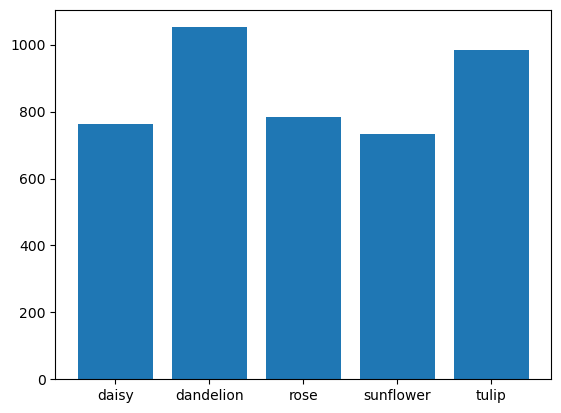

In [155]:
# [0.5 point] for this code block
# TODO: YOUR CODES HERE
plt.bar(dataset.classes, value_counts)

**Do we need to handle the imbalance? What do you think**

Even though dandelion and tulip has more images compared to sunflower, the overal data distribution across the flower types seems balanced. No need to handle imbalance. Removing the data or adding identical data to even out the dataset will be more harmful than the slight imbalance in the dataset as it is now. 

**Let's see how the images from the original dataset look like without changes:**

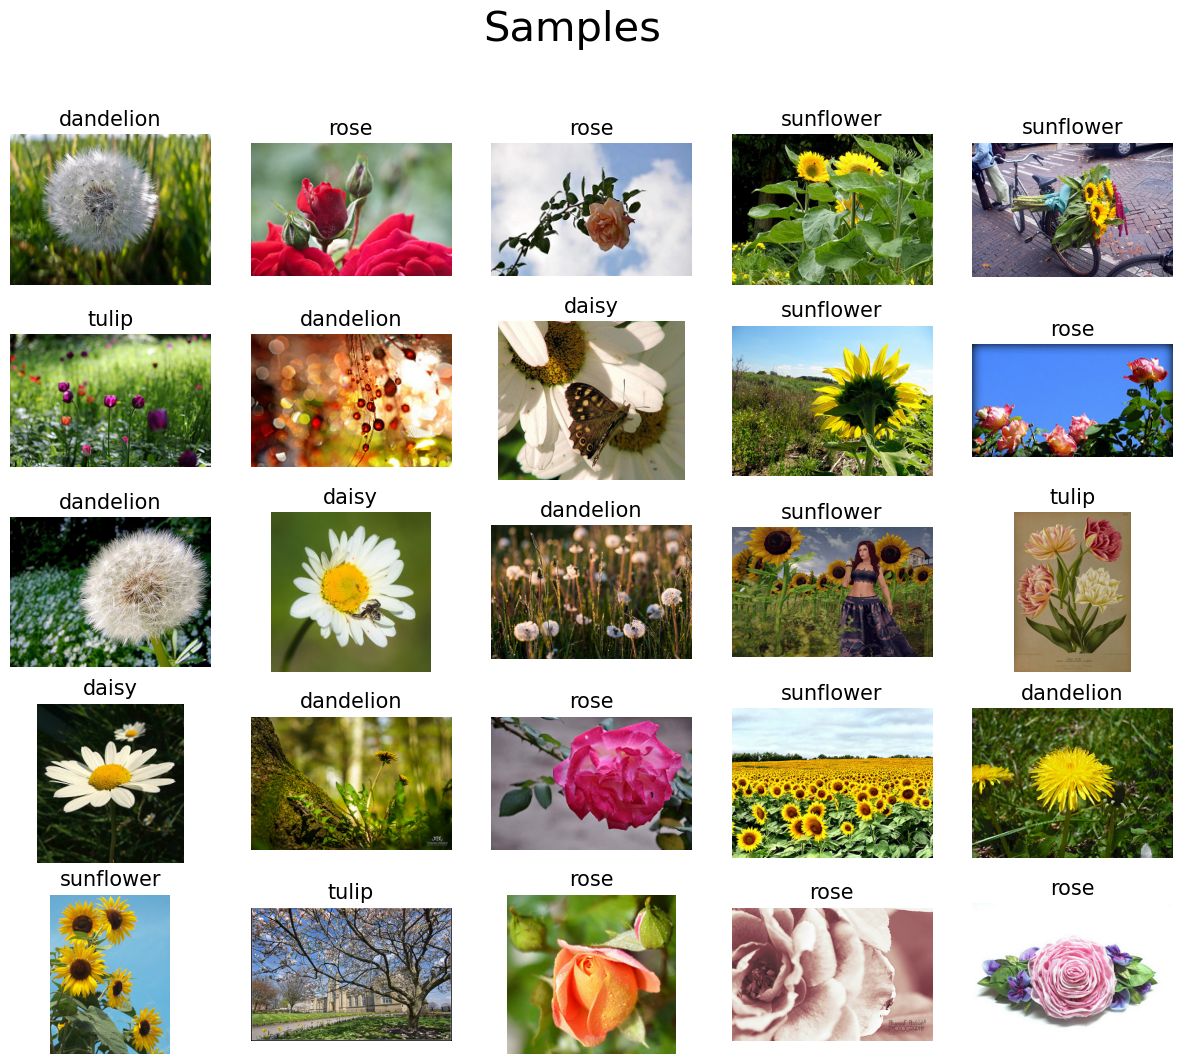

In [156]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(dataset.classes)
    rand_samples.append([random.sample([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

**And this is how images with augmentation look like**

In [ ]:
# [1 point] for this code block
def show_batch(dl):
    for images, labels in dl:
        # TODO: YOUR CODES HERE
        
show_batch(loaders['train'])

# 3. Training and Test

In order not to count the accuracy many times, we write the function to compute the classification accuracy between prediction and ground truth.

In [ ]:
# [1 point] for this code block
def accuracy(outputs, labels):
    # TODO: YOUR CODES HERE

**This is where we will record the history of learning, so that we can make visualization later. We need visualization to evaluate learning, for example, overfitting or underfitting. Of course, we can analyze with numbers, but it is much easier to perceive information visually**

In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

### Train function structure:
TODO list:
* define loss, optimizer
* set different behavior of model for train and validation step
* keep the record of loss and accuracy 
* keep the best model

In [ ]:
# [5 point] for this code block
def train(epochs, model):
    
    model.to(device)  
    # TODO: YOUR CODES HERE
    
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                # TODO: YOUR CODES HERE
            else:
                # TODO: YOUR CODES HERE
      
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in loaders[phase]:
                # TODO: YOUR CODES HERE
                    
                if phase == 'train':
                    # TODO: YOUR CODES HERE
                    
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

    time_elapsed = time.time() - since
    print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
    print('=='*31)

    return model

# MODELS

**Let's use pretrained ResNet model**

In [ ]:
resnet34 = torchvision.models.resnet34(pretrained=True)
for param in resnet34.parameters():
    param.grad_requires = False

# replace the last layer as a new classifier, which is suitable for our data
resnet34.fc = # TODO: YOUR CODES HERE

**Launching training**

In [ ]:
epochs = 10

train(epochs=epochs, model=resnet34)

# 4. Loss and Accuracy Plots

**Visualize the accuracy and loss of train and validation set during the model learning**

In [ ]:
# [0.5 point] for this code block
# plot of train and validation accuracy, vs epoch number
# TODO: YOUR CODES HERE 

In [ ]:
# [0.5 point] for this code block
#plot of train and validation loss, vs epoch number
# TODO: YOUR CODES HERE 

# 5. Test set predictions

**These functions will help us when calculating the accuracy**

In [ ]:
# [1 point] for this code block
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    
    # TODO: YOUR CODES HERE 
    
    # return prediction and label
    return results['test_preds'], results['test_labels']

**What's the loss and accuracy of the test set?**

In [ ]:
model=resnet34
model.to(device)
preds,labels = test_predict(model, loaders['test'])

# 6. Metrics

In [ ]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=original.classes)
report_df = pd.DataFrame(report).transpose()

In [ ]:
pd.set_option("display.max_rows", None)
report_df.head(134)

In [ ]:
# [0.5 point] for this code block
# Plot confusion matrix
# TODO: YOUR CODES HERE 

# 7. Predictions of individual images in test set

**The function below will normalize the image back to its original. It simply multiplies the tensor by the standard deviation and adds the mean**

In [ ]:
def norm_out(img):
    
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.4124234616756439, 0.3674212694168091, 0.2578217089176178])
    std = torch.FloatTensor([0.3268945515155792, 0.29282665252685547, 0.29053378105163574])
    
    img = img*std + mean
        
    return np.clip(img,0,1)

In [ ]:
# [1.5 point] for this code block
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)
num_of_img = 4
for row in range(num_of_img):
    # randomly pick an example from test set
    # TODO: YOUR CODES HERE 
    img,label = 
    
    # get the prediction
    # TODO: YOUR CODES HERE 
    pred = 
    
    # plot the image and check the prediction



***I hope you enjoyed it and found something new for yourself!* <br/>
*For improvement, what do you think can be changed and what can be removed?*** <br/>
how about batch size? model? unfreeze parameters? augmentation? <br/>
[1 bonus point] for the answer